In [1078]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import LabelEncoder

import re

from IPython.display import display
pd.options.display.max_columns = 500

## Import data set

In [1079]:
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')

In [1080]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## Outliers

In [1081]:
# remove outliers
train = train[~((train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000))]
train = train[~((train['MasVnrArea'] > 1400) & (train['SalePrice'] < 300000))]
train = train[~((train['LotFrontage'] > 300) & (train['SalePrice'] < 300000 ))]
train = train[~((train['LotArea'] > 200000) & (train['SalePrice'] < 500000 ))]
# train = train[~((train['YearBuilt'] < 1900) & (train['SalePrice'] > 400000))]
train = train[~((train['OpenPorchSF'] > 500) & (train['SalePrice'] < 100000))]


## Remove SalePrice and Id

In [1082]:
response_variable = np.log1p(train.SalePrice)
id_ = test.Id
train = train.loc[:,'MSSubClass':'SaleCondition']
test = test.loc[:,'MSSubClass':'SaleCondition']

## Multicoliearity 

We need to add justification

In [1083]:
# drop some features to avoid multicollinearity

train.drop(['1stFlrSF','GarageArea', 'TotRmsAbvGrd'], axis=1, inplace=True)
test.drop(['1stFlrSF','GarageArea','TotRmsAbvGrd'], axis=1, inplace=True)

## Skewdness

In [1084]:
numeric_feats = train.dtypes[train.dtypes != "object"].index


skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > .65]

skewed_index = skewed_feats.index

train[skewed_index] = boxcox1p(train[skewed_index], 0.1)
test[skewed_index] = boxcox1p(test[skewed_index], 0.1)

ss = StandardScaler()
train[skewed_index] = ss.fit_transform(train[skewed_index])
test[skewed_index] = ss.transform(test[skewed_index])

## Imputation

In [1085]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Ordnial

In [1086]:
# ords = []
# for col in train:
#     if 'Ex' in set(train[col]):
#         ords.append(col)

In [1087]:
# ord_values = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}

In [1088]:
# for ordn in ords:
#     train[ordn] = train[ordn].map(ord_values)

In [1089]:
# train[ords] = train[ords].fillna(0)

## Dummification

In [1090]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [1091]:
train_cols = set(train.columns)
test_cols = set(test.columns)

test_drop =  list(test_cols - train_cols)
test_unkonwn_dummies = list(train_cols - test_cols)

In [1092]:
test_dummies = test.reindex(columns=test_unkonwn_dummies, fill_value=0)

In [1093]:
test = pd.concat([test, test_dummies], axis=1)

In [1094]:
test = test[train.columns]

In [1095]:
train['SalePrice'] = response_variable

# Feature Engineering

## Age

In [1096]:
# range_bins = [(1800,1900), (1900,1910), (1910,1920), (1920,1930), (1930,1940), (1940,1950), (1950,1960), (1960,1970), (1970,1980), (1980,1990), (1990,2000), (2000,2011)]

# bins = {r:x for (x,y) in range_bins for r in range(x,y)}

# train['YearBuilt'] = train['YearBuilt'].map(bins)

# test['YearBuilt'] = test['YearBuilt'].map(bins)

In [1097]:
# train['YearBuilt'] = train['YrSold'] - train['YearBuilt']
# test['YearBuilt'] = test['YrSold'] - test['YearBuilt']

In [1098]:
# train[['Age']] = train[['YearBuilt']].apply(lambda x: x.max() - x)
# # train = train.drop('YearBuilt', axis=1)
# test[['Age']] = test[['YearBuilt']].apply(lambda x: x.max() - x)
# test = test.drop('YearBuilt', axis=1)

## Garage Age

In [1099]:
# test['GarageYrBlt'] = test['GarageYrBlt'].isna().apply(lambda x: int(not x))

In [1100]:
# train['GarageYrBlt'] = train['GarageYrBlt'].isna().apply(lambda x: int(not x))

In [1101]:
# train['GarageYrBlt'] = train['YrSold'] - train['GarageYrBlt']
# test['GarageYrBlt'] = test['YrSold'] - test['GarageYrBlt']

## SF

In [1102]:
# train.drop('TotalBsmtSF', axis= 1, inplace=True)
# test.drop('TotalBsmtSF', axis= 1, inplace=True)


# train['TwoStory'] = train['2ndFlrSF'].isna().apply(lambda x: int(not x))
# test['TwoStory'] = test['2ndFlrSF'].isna().apply(lambda x: int(not x))

# train['SF'] = train['1stFlrSF'] + train['2ndFlrSF']
# # train.drop(['1stFlrSF','2ndFlrSF'], axis= 1, inplace=True)

# test['SF'] = test['1stFlrSF'] + test['2ndFlrSF']
# test.drop(['1stFlrSF','2ndFlrSF'], axis= 1, inplace=True)

## YearRemodAdd

In [1103]:
# train['YearRemodAdd']  = (train['YrSold'] - train['YearRemodAdd'])
# test['YearRemodAdd']  = (test['YrSold'] - test['YearRemodAdd'])

# Pickel

In [1106]:
train.to_pickle('train.pkl')
test.to_pickle('test.pkl')
response_variable.to_pickle('y_train.pkl')

## Train Test Split

In [1073]:
X_train = train.drop('SalePrice', axis=1)
X_test = test
y_train = response_variable

## Modeling

In [1074]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

lasso = Lasso(max_iter=5000)

alphas =np.logspace(-4, -2, 100)

grid = GridSearchCV(estimator=lasso,
    param_grid=dict(alpha=alphas), cv=10, scoring='r2')

grid.fit(X_train, y_train)

y_hats = grid.best_estimator_.predict(X_train)
test_predictions = np.expm1(grid.best_estimator_.predict(X_test))

grid.best_estimator_.fit(X_train, y_train)
grid.best_estimator_.score(X_train, y_train)
grid.best_estimator_

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

## Prediciton

Text(0.5,1,'Model prediction vs Actual Sale price')

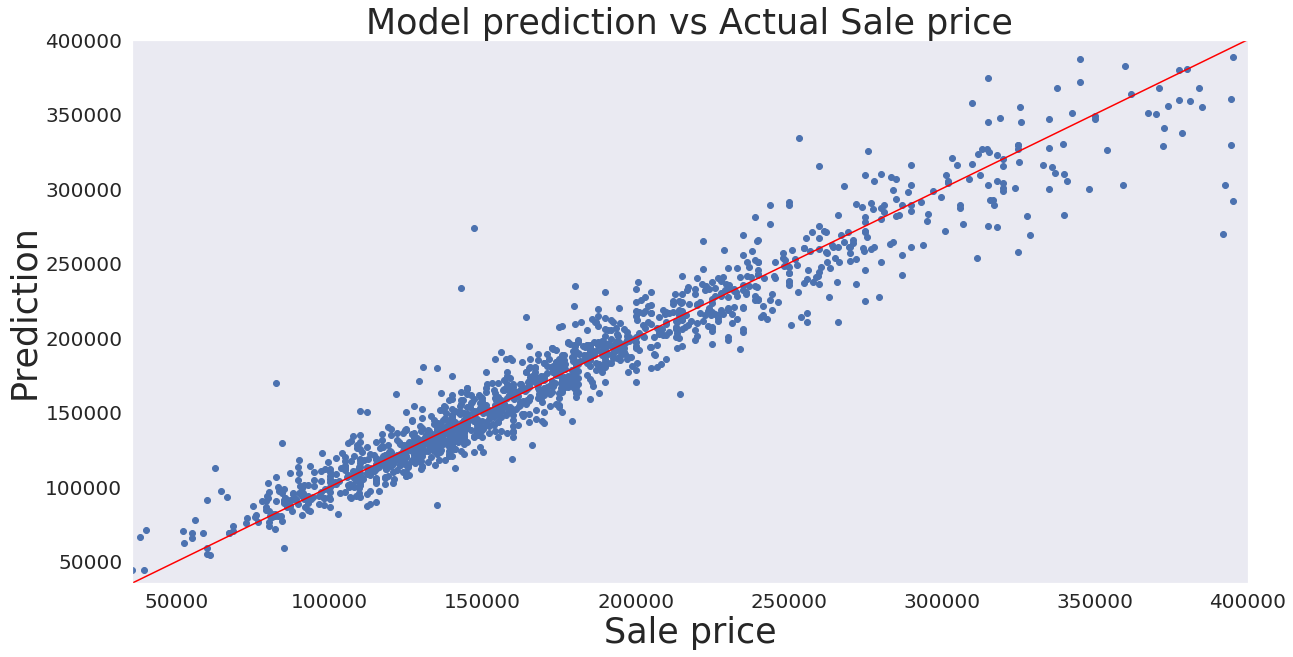

In [841]:
true_line = np.linspace(0, np.expm1(y_train.max()), 50)
predictios = pd.DataFrame({'y_hat': np.expm1(y_hats), 'y': np.expm1(y_train)})


ylabel = '$y_{train}$'
xlabel = r'$\hat{f}(\mathbf{X}_{train})$' 
#= \hat{{\beta}}\mathbf{X}_{train}$'

plt.figure(figsize=(20,10))
plt.scatter(x=predictios.y, y=predictios.y_hat)
line = plt.plot(true_line,
    true_line,  c='red')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid()
plt.ylim((predictios.y.min(),400000))
plt.xlim((predictios.y.min(),400000))
plt.xlabel('Sale price', fontsize=35)
plt.ylabel('Prediction', fontsize=35)
plt.title('Model prediction vs Actual Sale price',fontsize=35)

In [842]:
coef_df = pd.DataFrame({'cols': X_train.columns,'coef': grid.best_estimator_.coef_}, index=X_train.columns )

In [1006]:
pd.DataFrame({'Id': test_raw['Id'], 'SalePrice': test_predictions}).to_csv('predictions.csv', index=False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f predictions.csv -m "Message"